In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

symbols = ["RYAAY", "KO", "FB", "MSFT", "UNH", "TSLA", "VOYA", "HON", "LPX", "CNP"]
train_start_date = '2015-01-01'
train_end_date = '2017-12-31'
 
train_close_prices = yf.download(symbols, train_start_date, train_end_date)['Close']

[*********************100%***********************]  10 of 10 completed


In [9]:
def get_estimated_return(daily_returns_mean, weights) -> float:
    return np.sum(daily_returns_mean * weights) * 252

def get_risk(covariance_matrix, weights) -> float:
    return np.sum(np.sqrt(weights @ covariance_matrix @ weights.T) * np.sqrt(252))

def get_sharp_ratio(daily_returns_mean, covariance_matrix, weights) -> float:
    return get_estimated_return(daily_returns_mean, weights) / get_risk(covariance_matrix, weights)

In [10]:
print(train_close_prices.shape)

(756, 10)


In [11]:
class Portfolio:
    def __init__(self, daily_returns, weights):
        self.__daily_returns = daily_returns
        self.__weights = weights
        self.__daily_returns_mean = []
        self.__cov_matrix = []
        self.__estimated_return = None
        self.__risk = None
        self.__sharp_ratio = None

    def get_daily_returns(self):
        return self.__daily_returns

    def get_weights(self):
        return self.__weights

    def get_daily_returns_mean(self):
        if len(self.__daily_returns_mean) == 0:
            self.__daily_returns_mean = self.__daily_returns.mean()
        return self.__daily_returns_mean

    def get_cov_matrix(self):
        if len(self.__cov_matrix) == 0:
            self.__cov_matrix = self.__daily_returns.cov()
        return self.__cov_matrix

    def get_estimated_return(self):
        if self.__estimated_return == None:
            self.__estimated_return = get_estimated_return(self.get_daily_returns_mean(), self.__weights)
        return self.__estimated_return
    
    def get_risk(self):
        if self.__risk == None:
            self.__risk = get_risk(self.get_cov_matrix(), self.__weights)
        return self.__risk

    def get_sharp_ratio(self):
        if self.__sharp_ratio == None:
            self.__sharp_ratio = get_sharp_ratio(self.get_daily_returns_mean(), self.get_cov_matrix(), self.__weights)
        return self.__sharp_ratio
    
    def set_daily_returns(self, daily_returns):
        self.__daily_returns = daily_returns
        self.__daily_returns_mean = []
        self.__cov_matrix = []
        self.__estimated_return = None
        self.__risk = None
        self.__sharp_ratio = None
    
    def set_weights(self, weights):
        self.__weights = weights
        self.__estimated_return = None
        self.__risk = None
        self.__sharp_ratio = None


### Calculating optimal portfolio with empiristic method

In [12]:
num_port = 5000
daily_returns = train_close_prices.pct_change()[1:]

random_portfolios = []
all_returns = np.zeros((num_port))
all_risks = np.ones((num_port))

max_return_portfolio = None
min_risk_portfolio = None
max_ratio_portfolio = None

np.random.seed(42)

for i in range(num_port):

    # Portfolio weights
    wts = np.random.uniform(size=len(daily_returns.columns))
    wts = wts / np.sum(wts)

    current_port = Portfolio(daily_returns, wts)
    random_portfolios.append(current_port)

    # Save portfolios of interest (min var, max return and max SR)
    if max_return_portfolio == None or current_port.get_estimated_return() >= max_return_portfolio.get_estimated_return():
        max_return_portfolio = current_port
        
    if min_risk_portfolio == None or current_port.get_risk() <= min_risk_portfolio.get_risk():
        min_risk_portfolio = current_port

    if max_ratio_portfolio == None or current_port.get_sharp_ratio() >= max_ratio_portfolio.get_sharp_ratio():
        max_ratio_portfolio = current_port

In [ ]:
def plot_random_portfolios(title: str):
    plt.figure(figsize=(18, 10), facecolor='w')
    plt.title(title)
    
    all_port_risks = []
    all_port_returns = []
    for portfolio in random_portfolios:
        all_port_risks.append(portfolio.get_risk()*100)
        all_port_returns.append(portfolio.get_estimated_return()*100)

    plt.plot(all_port_risks, all_port_returns, 'bo', alpha=0.2)
    plt.plot(min_risk_portfolio.get_risk()*100, 
        min_risk_portfolio.get_estimated_return()*100, 'ro', 
        label='Portfolio with minimum variance')
    plt.plot(max_ratio_portfolio.get_risk()*100, 
        max_ratio_portfolio.get_estimated_return()*100, 'mo', 
        label='Portfolio with max Sharpe ratio')
    plt.plot(max_return_portfolio.get_risk()*100, 
        max_return_portfolio.get_estimated_return()*100, 'go', 
        label='Portfolio with max return')
        
    plt.xlabel('Volatility, or risk (standard deviation) (%)')
    plt.ylabel('Estimated annual return (%)')
    plt.legend(loc="best")

Max sharpe ratio portfolio: 
	Return = 21.839114299120816 %
	Risk = 14.65414660411607 %
	Sharp ratio = 1.490302703330853


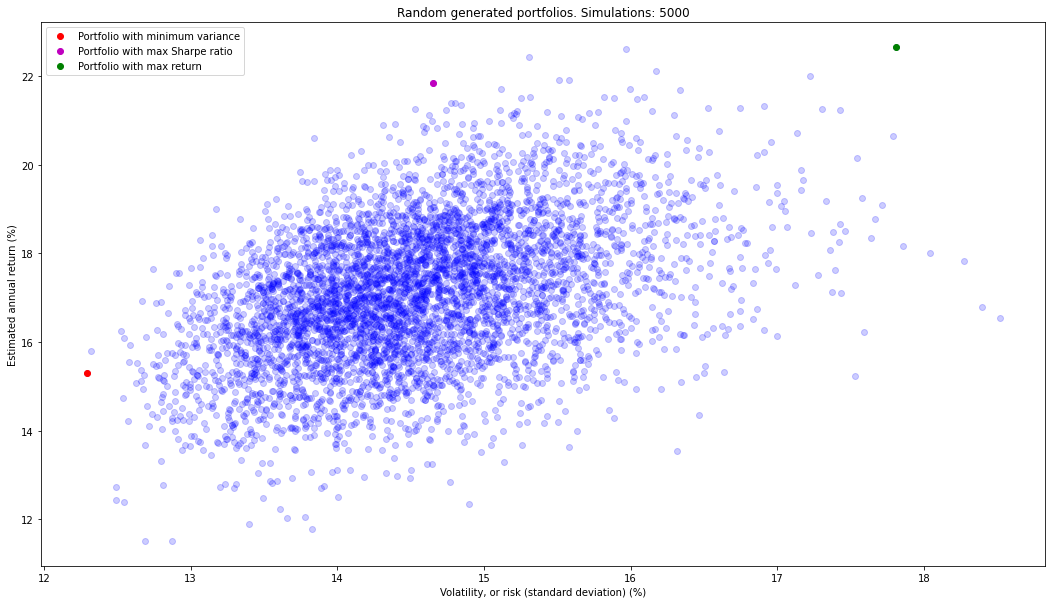

In [ ]:
print(
    'Max sharpe ratio portfolio:',
    '\n\tReturn =', max_ratio_portfolio.get_estimated_return()*100, '%'
    '\n\tRisk =', max_ratio_portfolio.get_risk()*100, '%'
    '\n\tSharp ratio =', max_ratio_portfolio.get_sharp_ratio()
)

plot_random_portfolios("Random generated portfolios. Simulations: " + str(num_port))
plt.show()

### -------------------------------------------------
### moj pokusaj matematicke optimizacije

In [ ]:
daily_returns = train_close_prices.pct_change()[1:]
covariance_matrix = daily_returns.cov()

def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

def check_risk(weights, *args):
    '''
    Returns 0 if risk is equal to acceptable_risk
    '''
    covariance_matrix = args[0]
    acceptable_risk = args[1] / 100.
    return get_risk(covariance_matrix, weights) - acceptable_risk

def get_negative_sharp_ratio(weights, *args):
    daily_returns_mean = args[0]
    covariance_matrix = args[1]
    return -get_sharp_ratio(daily_returns_mean, covariance_matrix, weights)

def custom_portfolio_opt(daily_returns, acceptable_risk_pct=None) -> list[float]:
    daily_returns_mean = daily_returns.mean()
    covariance_matrix = daily_returns.cov()
    # By convention of minimize function it should be a function that returns zero for conditions
    additional_for_risk = (covariance_matrix, acceptable_risk_pct)
    if acceptable_risk_pct == None:
        cons = ({'type':'eq','fun': check_sum})
    else:
        cons = ([
            {'type':'eq','fun': check_sum},
            {'type':'eq','fun': check_risk, 'args': additional_for_risk},
        ])

    # 0-1 bounds for each weight
    bounds = []
    for i in range(len(symbols)):
        bounds.append((0, 1))

    # Initial Guess (equal distribution)
    w = np.full(len(symbols), 1./len(symbols))

    additional_for_sharp_ratio = (daily_returns_mean, covariance_matrix)
    # Sequential Least SQuares Programming (SLSQP).
    opt_results = minimize(fun=get_negative_sharp_ratio, args=additional_for_sharp_ratio, 
        x0=w, method = 'SLSQP', bounds=bounds, constraints=cons)

    return opt_results.x

In [ ]:
efficient_frontier_portfolios = []
daily_returns = train_close_prices.pct_change()[1:]
for i in range(33, 60):
    risk = i/3.
    weights = custom_portfolio_opt(daily_returns, risk)
    portfolio = Portfolio(daily_returns, weights)
    efficient_frontier_portfolios.append(portfolio)

frontier_risks = []
frontier_returns = []
for portfolio in efficient_frontier_portfolios:
    frontier_risks.append(portfolio.get_risk()*100)
    frontier_returns.append(portfolio.get_estimated_return()*100)
    
plot_random_portfolios("Efficient Frontier")
plt.plot(frontier_risks, frontier_returns, 'y-o')
plt.show()

In [ ]:
daily_returns = train_close_prices.pct_change()[1:]
covariance_matrix = daily_returns.cov()

plt.figure(figsize=(18, 10), facecolor='w')
plt.title("Efficient Frontier")
plt.plot(frontier_risks, frontier_returns, 'y-o')

#uniform portfolio
uniform_w = np.full(len(symbols), 1./len(symbols))
uniform_port_return = ((train_close_prices.iloc[-1]/train_close_prices.iloc[0] - 1) * uniform_w).sum() / 3
plt.plot(get_risk(covariance_matrix, uniform_w)*100, uniform_port_return*100, 'co', label='Unifrom portfolio')

#optimal portfolio with same risk as unifrom portfolio
fixed_risk_weights = custom_portfolio_opt(daily_returns, get_risk(covariance_matrix, uniform_w)*100)
fixed_risk_port = Portfolio(daily_returns, fixed_risk_weights)
plt.plot(fixed_risk_port.get_risk()*100, fixed_risk_port.get_estimated_return()*100, 'mo', label='Portfolio with same risk as unifrom')

#optimal portfolio, portfolio with max sharp ratio
optimal_weights = custom_portfolio_opt(daily_returns)
optimal_port = Portfolio(daily_returns, optimal_weights)
plt.plot(optimal_port.get_risk()*100, optimal_port.get_estimated_return()*100, 'go', label='Max sharp ratio portfolio')

plt.xlabel('Volatility, or risk (standard deviation) (%)')
plt.ylabel('Estimated annual return (%)')
plt.legend(loc="best")
plt.show()

### Periodično podešavanje težina

In [ ]:
import bt
def get_realized_return(price_data, tickers):
    '''
    data = bt.get(",".join(symbols), 
        start=startDate, 
        end=endDate)
    '''
    strategy = bt.Strategy('test', [
        bt.algos.RunOnce(),
        bt.algos.SelectAll(),
        bt.algos.WeighSpecified(**tickers),
        bt.algos.Rebalance()])
    test = bt.Backtest(strategy, price_data)
    res = bt.run(test)
    return res.stats.loc[['total_return']]['test'].item()

def test_portfolio(test_start_date, test_end_date, acceptable_risk_pct=None):
    test_close_prices = yf.download(symbols, test_start_date, test_end_date)['Close']
    start_budget = 1000

    custom_weights = np.full(len(symbols), 1./len(symbols))
    custom_budget_tracker = []
    date_tracker = []
    custom_budget_tracker.append(start_budget)
    date_tracker.append(test_close_prices.index[0])

    uniform_w = np.full(len(symbols), 1./len(symbols))
    uniform_tickers = {}
    for i in range(len(symbols)):
        uniform_tickers[symbols[i]] = uniform_w[i]
    unifrom_port_budget_tracker = []
    unifrom_port_budget_tracker.append(start_budget)

    custom_port_data = {
    'risks': [],
    'returns': []
    }
    unifrom_port_data = {
    'risks': [],
    'returns': []
    }
    history_prices = test_close_prices.iloc[:11,:]
    ten_days_prices = test_close_prices.iloc[:11,:]
    i = 1
    while 10*(i-1) <= len(test_close_prices):
        #calculating return of custom portfolio
        custom_tickers = {}
        for j in range(len(symbols)):
            custom_tickers[symbols[j]] = custom_weights[j]
        realized_return = get_realized_return(ten_days_prices, custom_tickers)
        custom_budget_tracker.append(custom_budget_tracker[-1] * (1 + realized_return))

        date_tracker.append(ten_days_prices.index[-1])
        
        #calculating return of uniform portfolio
        realized_return = get_realized_return(ten_days_prices, uniform_tickers)
        unifrom_port_budget_tracker.append(unifrom_port_budget_tracker[-1] * (1 + realized_return))

        #find new weights
        if 10*(i+1)+1 <= len(test_close_prices):
            daily_returns = history_prices.pct_change()[1:]
            covariance_matrix = daily_returns.cov()

            custom_weights = custom_portfolio_opt(daily_returns, acceptable_risk_pct)
            
            custom_port_data['risks'].append(get_risk(covariance_matrix, custom_weights)*100)
            custom_port_data['returns'].append(get_estimated_return(daily_returns.mean(), custom_weights)*100)
            unifrom_port_data['risks'].append(get_risk(covariance_matrix, uniform_w)*100)
            unifrom_port_data['returns'].append(get_estimated_return(daily_returns.mean(), uniform_w)*100)

        #prepare data for new iteration
        ten_days_prices = test_close_prices.iloc[10*i:10*(i+1)+1,:]
        history_prices = test_close_prices.iloc[10*(i-2):10*(i+1)+1,:]
        i += 1

    print('Custom portfolio:', custom_budget_tracker[-1])
    print('Uniform portfolio:', unifrom_port_budget_tracker[-1])

    plt.figure(figsize=(12, 8))
    plt.plot(custom_port_data['risks'], custom_port_data['returns'], 
    'bo', alpha=0.2, label='Custom portfolio')
    plt.plot(unifrom_port_data['risks'], unifrom_port_data['returns'], 
    'ro', alpha=0.2, label='Uniform portfolio')
    plt.xlabel('Risk (%)')
    plt.ylabel('Return (%)')
    plt.legend(loc="best")
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.plot(date_tracker, custom_budget_tracker, label='Custom portfolio')
    plt.plot(date_tracker, unifrom_port_budget_tracker, label='Uniform portfolio', color='red')
    plt.xlabel('Date')
    plt.ylabel('Budget ($)')
    plt.legend(loc="best")
    plt.show()

In [ ]:
test_portfolio('2018-01-01', '2019-12-31', 10)

In [ ]:
test_portfolio('2018-01-01', '2019-12-31')

In [ ]:
test_portfolio('2020-01-01', '2021-12-31', 15)

In [ ]:
test_portfolio('2019-01-01', '2020-12-31')

In [ ]:
test_portfolio('2018-01-01', '2021-12-31')

In [ ]:
test_portfolio('2018-01-01', '2021-12-31', 25)

In [ ]:
test_portfolio('2020-03-20', '2020-07-31', 20)

In [ ]:
test_portfolio('2014-01-01', '2022-04-01')